# Better Solving Heavily Unbalanced Classification Problems With KXY


## TL'DR

Training a classifier with a heavily unbalanced dataset typically results in too many false-negatives. 

When it is not possible to change the loss function to account for class imbalance, subsampling the most frequent class prior to training is an appealing alternative. However, subsampling strategies can produce subsets that are not representative of the distribution sampled from, which may result in too many false-positives in production.

In this case study, we use the [UCI Bank Marketing dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing) to illustrate how the `kxy` package can be used to quantify subsampling bias, and to determine which explanatory variables are the most affected by subsampling bias, so as to remedy the issue.

## I. The Problem: Unbalanced Classification Problems Yield Too Many False-Negatives

Consider a heavily unbalanced binary classification problem (i.e. one where positive outcomes are far rarer than negative ones). Examples include fraud detection, claim prediction, network attack detection, telemarketing campaign conversion, etc.

Assume we are given $n$ i.i.d. observations $(y_i, x_i)$, of which only $m \ll n$ are of class $1$, the other $n-m$ being of class $0$. For ease of notation, let us assume the first $m$ inputs are of class $1$, so that the log-likelihood reads $$\mathcal{LL}(\theta) = \sum_{i=1}^m \log q_\theta(1, x_i) + \sum_{i=m+1}^n \log q_\theta(0, x_i),$$ where the function $q_\theta: (y, x) \to q_\theta(y, x)$, which satisfies $q_\theta(1, x) + q_\theta(0, x) = 1$ for any $x$ and $\theta$, represents the probability that input $x$ is associated to class $y$ under the model corresponding to parameters $\theta$.

Because $m \ll n$, the term $\sum_{i=1}^m \log q_\theta(1, x_i)$, which is the contribution of positive outcomes to the overall log-likelihood $\mathcal{LL}(\theta)$, will tend to be negligible. Thus, maximizing $\mathcal{LL}(\theta)$ will likely result in a model with *a lot of false-negatives* (i.e. a model that predicts all explanatory variables correspond to class $0$).

This is very problematic because, in heavily unbalanced problems, accurately predicting the occurence of the least frequent class is usually where the value lies.


## II. A Popular Workaround: Subsampling Negative Observations

A simple workaround to this problem is to downsample the $n-m$ negative explanatory variables into a subset $(\tilde{x}_{m+1}, \dots, \tilde{x}_{m+k}) \subset (x_{m+1}, \dots, x_{n})$ of size $k$ that is close enough to $m$, and to maximize the new log-likelihood $$\mathcal{LL}_d(\theta) = \sum_{i=1}^m \log q_\theta(1, x_i) + \sum_{i=m+1}^{m+k} \log q_\theta(0, \tilde{x}_i).$$

**Remark:** When $m$ is large enough, subsampling negative samples is equivalent to the alternative approach consisting of keeping all observations, and maximizing the weighted likelihood $$\mathcal{LL}_\omega(\theta) = (1-\omega) \sum_{i=1}^m \log q_\theta(1, x_i) + \omega \sum_{i=m+1}^{n} \log q_\theta(0, x_i), ~~~~ \text{with} ~~ \omega = \frac{k}{n-m+k}.$$
However, subsampling has two advantages over reweighting the likelihood or loss function. First, because the subsampled likelihood utilizes fewer observations, subsampling will results in faster (and cheaper) model training than reweighting the likelihood. Second, subsampling does not require changing the loss function, which many toolkits might not allow the machine learning engineer to do.



## III. The Limits of Subsampling: Distribution Bias & Excessive False-Positives

Unfortunately, given that $k \approx m \ll n-m$, if not done carefully, the subsampling scheme risks introducing a bias in the distribution of explanatory variables corresponding to negative outcomes (i.e. our sampled subset $(\tilde{x}_{m+1}, \dots, \tilde{x}_{m+k})$ might not fully reflect the true conditional distribution $P_{x|y=0}$). 
Whenever the subsampling scheme is biased, a model trained by maximizing $\mathcal{LL}_d(\theta)$ would not know of certain parts of the distribution $P_{x|y=0}$ of negative explanatory variables. 

This can negatively affect model performance in two ways:


#### **Scenario A: Introduction of new (spurious) patterns**
A biased subsampling scheme can (unduly) exacerbate the difference between values of explanatory variables corresponding to $y=0$ and values corresponding to $y=1$, to the point of creating spurious patterns that a classifier might learn to rely on to tell one class apart from the other.

As an illustration, consider an explanatory variable $x$ that is uniformly distributed on $[0, 1]$ both when $y=0$ and when $y=1$. Let us also assume that the class-0 subsampler only selects values in $[\frac{1}{4}, \frac{3}{4}]$. 

Although $x$ is intrinsically *uninformative* about $y$, after subsampling class-0 observations, it no longer will be, at least not as per the sampled training set. This is because in the sampled training set, from the value of $x$ we can tell whether $y=1$ or $y=0$ more accurately than chance. Indeed, a value of $x$ outside of $[\frac{1}{4}, \frac{3}{4}]$ would be a strong indication that $y=1$.

The relationship between whether  $x$ is in $[\frac{1}{4}, \frac{3}{4}]$ and $y$ in the sampled training set, which is an artifact of the sampler, is a spurious pattern that a classifier can easily rely on to boost training performance, but that will not prevail out-of-sample.

#### **Scenario B: Destruction of existing (valid) patterns**
It may happen that, in the part of the inputs space from which the biased subsampling scheme (mostly) samples, there is no relationship between the inputs/explanatory variables and the target, but in the rest of the inputs space the relationship is much stronger. Whenever this happens, the bias would effectively be destroying valid patterns relating inputs/explanatory variables to the target.

As an illustration, consider an input $x$ that is uniformly distributed on $[\frac{1}{4}, \frac{3}{4}]$ when $y=1$ but uniformly distributed on $[0, 1]$ when $y=0$. 

Clearly, $x$ is useful to predict $y$, as a value of $x$ outside of $[\frac{1}{4}, \frac{3}{4}]$ is a strong indication that $y=0$. 

Let us now assume that the class-0 subsampler only samples values in $[\frac{1}{4}, \frac{3}{4}]$. Because $x$ is now uniformly distributed on $[\frac{1}{4}, \frac{3}{4}]$ whether $y=0$ or $y=1$, we can no longer tell the two classes apart using $x$ (i.e. $x$ has become uninformative about $y$). 

In other words, no classifier trained using the biased training set will be able to find any reliable pattern relating $x$ to $y$.

Overall, a bias subsampler will always either create new spurious patterns in the data, destroy valuable patterns, or do both. Whatever the case may be, this will ultimately result in any model trained using the biased subsampled training set performing much poorer in production than expected. 

In production, whenever a set of explanatory variables will come from the unseen part of the distribution $P_{x|y=0}$, a model trained using the biased (but balanced) subsampled training set will have a 50/50 chance of predicting that the associated class is $1$, even though class-1 observations are far less frequent than class-0 observations. 

This will typically manifest itself in an excessive number of false-positives.



## IV. The Solution: Quantifying and Avoiding Subsampling Bias With KXY

To avoid these excessive false-positives, we need to be able to quantify how much bias an iteration of a sampler induces. This is where the `kxy` package comes in.

Let $s_i, m < i \leq n$ be the indicator variable taking value $1$ if and only if the i-th sample $x_i$ is selected by the subsampling scheme, and $0$ otherwise.

Fundamentally, the subsampling scheme used induced a bias in the empirical distribution of class-0 explanatory variables if and only if we may find a binary classifier that can predict $s_i$ solely from knowing $x_i$ better than chance (i.e. with an accuracy higher than $\max \left(1-\frac{k}{n-m}, \frac{k}{n-m} \right)$).

By using the `kxy` package to compute the highest performance achievable when using $x_i$ to predict $s_i$ for $i>m$, we may quantify the amount of bias the subsampler induced. 

A subsampler generates a bias-free partition of our empirical distribution of class-0 explanatory variables when the highest classification accuracy achievable is as close to $\max \left(1-\frac{k}{n-m}, \frac{k}{n-m} \right)$ as possible. 

The higher the achievable accuracy, the higher the bias introduced. As previously discussed, any bias introduced by a subsampler is likely to have adverse consequences, so it is important to always quantify the bias before training a model with a subsampled training set.


## V. Illustration On A Real-Life Dataset

We apply the solution above to the [UCI Bank Marketing dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). 

The problem consists of predicting whether clients of a bank will subscribe a new product (bank term deposit). In the dataset, only 11% of clients subscribed, 89% did not.


### 1. Data Visualization

In [1]:
import numpy as np
import pandas as pd
import kxy
from kxy_datasets.uci_classifications import BankMarketing # pip install kxy_datasets
dataset = BankMarketing()
df = dataset.df # Retrieve the dataset as a pandas dataframe
y_column = dataset.y_column # The name of the column corresponding to the target
problem_type = dataset.problem_type # 'regression' or 'classification'
df.kxy.describe() # Visualize a summary of the data

         
-----------
Column: age
-----------
Type:   Continuous
Max:    98
p75:    47
Mean:   40
Median: 38
p25:    32
Min:    17
         
----------------
Column: campaign
----------------
Type:   Continuous
Max:    56
p75:    3.0
Mean:   2.6
Median: 2.0
p25:    1.0
Min:    1.0
         
---------------------
Column: cons.conf.idx
---------------------
Type:   Continuous
Max:    -26.9
p75:    -36.4
Mean:   -40.5
Median: -41.8
p25:    -42.7
Min:    -50.8
         
----------------------
Column: cons.price.idx
----------------------
Type:   Continuous
Max:    94
p75:    93
Mean:   93
Median: 93
p25:    93
Min:    92
         
---------------
Column: contact
---------------
Type:      Categorical
Frequency: 63.47%, Label: cellular
Frequency: 36.53%, Label: telephone
         
-------------------
Column: day_of_week
-------------------
Type:      Categorical
Frequency: 20.94%, Label: thu
Frequency: 20.67%, Label: mon
Frequency: 19.75%, Label: wed
Frequency: 19.64%, Label: tue
Frequency:

### 2. Categorical Encoding

In [2]:
# One-hot encoding of categorical features, and categorical encoding of the target
df_encoded = df.kxy.ordinally_encode(target_column=y_column, method='one_hot')
df_encoded.kxy.describe()

         
-----------
Column: age
-----------
Type:   Continuous
Max:    98
p75:    47
Mean:   40
Median: 38
p25:    32
Min:    17
         
----------------
Column: campaign
----------------
Type:   Continuous
Max:    56
p75:    3.0
Mean:   2.6
Median: 2.0
p25:    1.0
Min:    1.0
         
---------------------
Column: cons.conf.idx
---------------------
Type:   Continuous
Max:    -26.9
p75:    -36.4
Mean:   -40.5
Median: -41.8
p25:    -42.7
Min:    -50.8
         
----------------------
Column: cons.price.idx
----------------------
Type:   Continuous
Max:    94
p75:    93
Mean:   93
Median: 93
p25:    93
Min:    92
         
------------------------
Column: contact_cellular
------------------------
Type:   Continuous
Max:    1.0
p75:    1.0
Mean:   0.6
Median: 1.0
p25:    0.0
Min:    0.0
         
-------------------------
Column: contact_telephone
-------------------------
Type:   Continuous
Max:    1.0
p75:    1.0
Mean:   0.4
Median: 0.0
p25:    0.0
Min:    0.0
         
----------

Type:   Continuous
Max:    1.0
p75:    0.0
Mean:   0.2
Median: 0.0
p25:    0.0
Min:    0.0
         
-----------------
Column: month_jun
-----------------
Type:   Continuous
Max:    1.0
p75:    0.0
Mean:   0.1
Median: 0.0
p25:    0.0
Min:    0.0
         
-----------------
Column: month_mar
-----------------
Type:   Continuous
Max:    1.0
p75:    0.0
Mean:   0.0
Median: 0.0
p25:    0.0
Min:    0.0
         
-----------------
Column: month_may
-----------------
Type:   Continuous
Max:    1.0
p75:    1.0
Mean:   0.3
Median: 0.0
p25:    0.0
Min:    0.0
         
-----------------
Column: month_nov
-----------------
Type:   Continuous
Max:    1.0
p75:    0.0
Mean:   0.1
Median: 0.0
p25:    0.0
Min:    0.0
         
-----------------
Column: month_oct
-----------------
Type:   Continuous
Max:    1.0
p75:    0.0
Mean:   0.0
Median: 0.0
p25:    0.0
Min:    0.0
         
-----------------
Column: month_sep
-----------------
Type:   Continuous
Max:    1.0
p75:    0.0
Mean:   0.0
Median: 0.0
p25

### 3. Train/Test Split
There are 41,188 observations in total, of which 36,548 of class 'no' (numerically represented as 0) and 4,640 of class 'yes' (numerically represented as 1). 

We reserve 1,000 observations of class 'yes' and 9,000 observations of class 'no' for testing. It is important to preserve the class imbalance in the testing set to ensure testing errors are indicative of what could happen in production. 

The remaining observations are available for training.

In [3]:
test_size_pos = 1000
test_size_neg = 9000
pos_df = df_encoded[df_encoded[y_column]==1.0]\
    .sample(frac=1, random_state=0)\
    .reset_index(drop=True) # Positive samples shuffled
pos_df_test  = pos_df.iloc[:test_size_pos]
pos_df_train = pos_df.iloc[test_size_pos:]

neg_df = df_encoded[df_encoded[y_column]==0.0]\
    .sample(frac=1, random_state=0)\
    .reset_index(drop=True) # Negative samples shuffled
neg_df_test  = neg_df.iloc[:test_size_neg]
neg_df_train = neg_df.iloc[test_size_neg:]

df_train = pd.concat([pos_df_train, neg_df_train], axis=0)
df_test = pd.concat([pos_df_test, neg_df_test], axis=0)

feature_columns = [col for col in df_encoded.columns if col != y_column]
x_train = df_train[feature_columns]
x_test = df_test[feature_columns]
y_train = df_train[y_column]
y_test = df_test[y_column]

### 4. Training Without Subsampler
We begin by illustrating that training a random forest classifier on this dataset without first reducing the class imbalance does indeed result in excessive false-negatives.

In [4]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import pylab as plt
import pandas as pd
pd.set_option('display.min_rows', 21)

In [5]:
clf_1 = RandomForestClassifier(max_depth=10, random_state=0)
clf_1.fit(x_train, y_train)
y_pred_1 = clf_1.predict(x_test)

#### Testing Confusion Matrix

In [6]:
conf_mat_1 = confusion_matrix(y_test, y_pred_1)
conf_mat_1 = pd.DataFrame(conf_mat_1, columns=['Predicted Would Not Subscribe', 'Predicted Would Subscribe'], \
                          index=['Did Not Subscribe', 'Subscribed'])
conf_mat_1

,Predicted Would Not Subscribe,Predicted Would Subscribe
Did Not Subscribe,8867,133
Subscribed,717,283


As expected, the trained classifier almost always predicts that clients would not subscribe the new product because this strategy has a very high likelihood on the heavily unbalanced training set. However, this model is not particularly useful.

## 5. Comparing Subsamplers
We move on to illustrating that, when it comes to subsampling strategies, bias typically result in excessive false-positives. 

We use the `kxy` package to find the explanatory variable that is the most insightful about the target. We then use a biased subsampler that destroys the value in that explanatory variable, and we compare it to a subsampler that is less biased.

### Variable Selection

In [7]:
df_train.kxy.variable_selection(y_column, problem_type='classification')

[====================================================================================================] 100% ETA: 0s    Duration: 0s


,Variable,Running Achievable R-Squared,Running Achievable Accuracy
Selection Order,,,
0,No Variable,0.00,0.88
1,duration,0.17,0.92
2,euribor3m,0.49,1.00
3,age,0.49,1.00
4,campaign,0.49,1.00
5,job_services,0.49,1.00
6,pdays,0.49,1.00
7,previous,0.49,1.00
8,emp.var.rate,0.49,1.00


In [8]:
df_train[['duration', y_column]].astype(int).groupby(by=[y_column]).mean()

,duration
y,
0,221.406382
1,553.169231


The most informative explanatory variable seems to be `duration`, with a boost over the 88% baseline accuracy of over 4%. Additionally, it would appear that clients that subscribed the product tend to have a much higher `duration` than clients that did't. 

To destroy this pattern we will create a random class-0 subsampler that only samples class-0 rows that have a duration higher than 300. We will then compare this subsampler with one that samples uniformly at random, which we expect to be less biased.

We will train a random forest classifier on both sampled training sets, and we will show that the most biased results in much more true-positives than the other.

Finally, we will show that not only can the `kxy` package automatically detect the bias we introduced in the `duration` variable, it also detects that the juice in the `duration` variable has decreased as a result of this bias.

### Subsamplers Construction

In [9]:
n_pos = pos_df_train.shape[0]
# Sampler 1 (duration-biased)
bias_selector = neg_df_train['duration'] > 300.0
neg_df_train_subsampler_1 = neg_df_train.copy()
bias_subsampler = np.cumsum(bias_selector.astype(float)) < n_pos # 1-to-1 0/1 ratio
bias_subsampler = np.logical_and(bias_subsampler, bias_selector)
neg_df_train_subsampler_1['selected'] = bias_subsampler.astype(float)
neg_df_train_1 = neg_df_train_subsampler_1[neg_df_train_subsampler_1['selected']==1.]
neg_df_train_1 = neg_df_train_1[[col for col in neg_df_train_1.columns if col != 'selected']]
df_train_1 = pd.concat([neg_df_train_1, pos_df_train])
x_train_1 = df_train_1[feature_columns]
y_train_1 = df_train_1[y_column]

# Sampler 2
neg_df_train_subsampler_2 = neg_df_train.copy()
neg_df_train_subsampler_2['selected'] = np.array([i<n_pos for i in range(neg_df_train.shape[0])])
neg_df_train_2 = neg_df_train_subsampler_2[neg_df_train_subsampler_2['selected']==1.]
neg_df_train_2 = neg_df_train_2[[col for col in neg_df_train_2.columns if col != 'selected']]
df_train_2 = pd.concat([neg_df_train_2, pos_df_train])
x_train_2 = df_train_2[feature_columns]
y_train_2 = df_train_2[y_column]

### Model Building

In [10]:
# Training model with sampler 1
clf_1 = RandomForestClassifier(max_depth=10, random_state=0)
clf_1.fit(x_train_1, y_train_1)

# Training model with sampler 2
clf_2 = RandomForestClassifier(max_depth=10, random_state=0)
clf_2.fit(x_train_2, y_train_2)

# Evaluation (Model 1)
y_pred_1 = clf_1.predict(x_test)
conf_mat_1 = confusion_matrix(y_test, y_pred_1)
conf_mat_1 = pd.DataFrame(conf_mat_1, columns=['Predicted Would Not Subscribe', 'Predicted Would Subscribe'], \
                          index=['Did Not Subscribe', 'Subscribed'])
n_exp = np.sum(conf_mat_1.values)
acc1 = (conf_mat_1.values[0, 0]+conf_mat_1.values[1, 1])/n_exp
fp1 = conf_mat_1.values[0, 1]/n_exp
fn1 = conf_mat_1.values[1, 0]/n_exp

# Evaluation (Model 2)
y_pred_2 = clf_2.predict(x_test)
conf_mat_2 = confusion_matrix(y_test, y_pred_2)
conf_mat_2 = pd.DataFrame(conf_mat_2, columns=['Predicted Would Not Subscribe', 'Predicted Would Subscribe'], \
                          index=['Did Not Subscribe', 'Subscribed'])
n_exp = np.sum(conf_mat_2.values)
acc2 = (conf_mat_2.values[0, 0]+conf_mat_2.values[1, 1])/n_exp
fp2 = conf_mat_2.values[0, 1]/n_exp
fn2 = conf_mat_2.values[1, 0]/n_exp

***Confusion Matrix (Duration-Biased Sampler)***

In [11]:
conf_mat_1

,Predicted Would Not Subscribe,Predicted Would Subscribe
Did Not Subscribe,6631,2369
Subscribed,261,739


In [12]:
print('(Duration-Biased Sampler) Accuracy: %.2f, False-Positives: %.2f, False-Negatives: %.2f' % (acc1, fp1, fn1))

(Duration-Biased Sampler) Accuracy: 0.74, False-Positives: 0.24, False-Negatives: 0.03


***Confusion Matrix (Other Sampler)***

In [13]:
conf_mat_2

,Predicted Would Not Subscribe,Predicted Would Subscribe
Did Not Subscribe,7421,1579
Subscribed,65,935


In [14]:
print('(Less Biased Sampler) Accuracy: %.2f, False-Positives: %.2f, False-Negatives: %.2f' % (acc2, fp2, fn2))

(Less Biased Sampler) Accuracy: 0.84, False-Positives: 0.16, False-Negatives: 0.01


As we expected, the random forest trained using the sampler that introduces a bias in `duration` results in substantially more false-positives (24% of held out clients) out-of-sample than the random forest trained using the other sampler (16% of held out clients).

Let us now turn to how the `kxy` package might help.

### Bias Analysis With The `kxy` Package
We begin by confirming that the `kxy` package can indeed detect the bias in sampler 1.

In [15]:
bias_columns = [col for col in neg_df_train_subsampler_1.columns if col != y_column]
bias_analysis_df_1 = neg_df_train_subsampler_1[bias_columns]
bias_analysis_df_1.kxy.variable_selection('selected', problem_type='classification')

[====================================================================================================] 100% ETA: 0s    Duration: 0s


,Variable,Running Achievable R-Squared,Running Achievable Accuracy
Selection Order,,,
0,No Variable,0.00,0.87
1,duration,0.39,0.97
2,euribor3m,0.51,0.99
3,age,0.51,0.99
4,marital_married,0.51,0.99
5,job_blue-collar,0.51,0.99
6,job_management,0.51,0.99
7,education_basic.4y,0.51,0.99
8,job_services,0.51,0.99


**Remark:** The `kxy` package was indeed able to determine that, among class-0 observations, those that were kept by the sampler are perfectly identifiable from those that were not, almost solely using the `duration` variable.

Let us now confirm that the `kxy` package can detect that the value of the `duration` variable was destroyed by sampler 1.

In [16]:
df_train_1.kxy.variable_selection(y_column, problem_type='classification')

[====================================================================================================] 100% ETA: 0s    Duration: 0s


,Variable,Running Achievable R-Squared,Running Achievable Accuracy
Selection Order,,,
0,No Variable,0.00,0.50
1,euribor3m,0.31,0.79
2,age,0.48,0.88
3,campaign,0.62,0.95
4,housing_no,0.67,0.97
5,duration,0.67,0.97
6,marital_married,0.67,0.97
7,education_university.degree,0.67,0.97
8,job_blue-collar,0.67,0.97


Indeed, `duration` switched from being the most important variable in the full training dataset, to being the fifth most important variable in the subsampled training dataset.

Finally, let us analyze the bias induced by the second sampler.

In [17]:
bias_analysis_df_2 = neg_df_train_subsampler_2[bias_columns]
bias_analysis_df_2.kxy.variable_selection('selected', problem_type='classification')

[====================================================================================================] 100% ETA: 0s    Duration: 0s


,Variable,Running Achievable R-Squared,Running Achievable Accuracy
Selection Order,,,
0,No Variable,0.00,0.87
1,duration,0.02,0.87
2,euribor3m,0.34,0.95
3,age,0.34,0.95
4,campaign,0.34,0.95
5,housing_no,0.34,0.95
6,job_admin.,0.34,0.95
7,education_professional.course,0.34,0.95
8,default_no,0.34,0.95


**Remark:** Even with a sampler that operates uniformly at random, we still can tell sampled class-0 rows from other class-0 rows better than chance. This shouldn't be surprising because, by reducing the sample size by almost 90%, we are almost guaranteed that the sampled subset will not properly cover the tails of our 63-dimensional distribution. The is bound to happen for large input dimensions and/or moderate (pre-sampling) sample sizes.

What is reassuring however is `kxy` has identified that the second sampler has not introduced any bias in marginal distributions, not even in their tails (no single explanatory variable can be used to tell sampled rows from other better than chance).

It takes at least 2 explanatory variables (`duration` and `euribor3m`) to see some evidence of bias, and the figue below easily confirms that this bias is tail-related. Additionally, the bias does not seem to increase when we consider up to 10 explanatory variables.

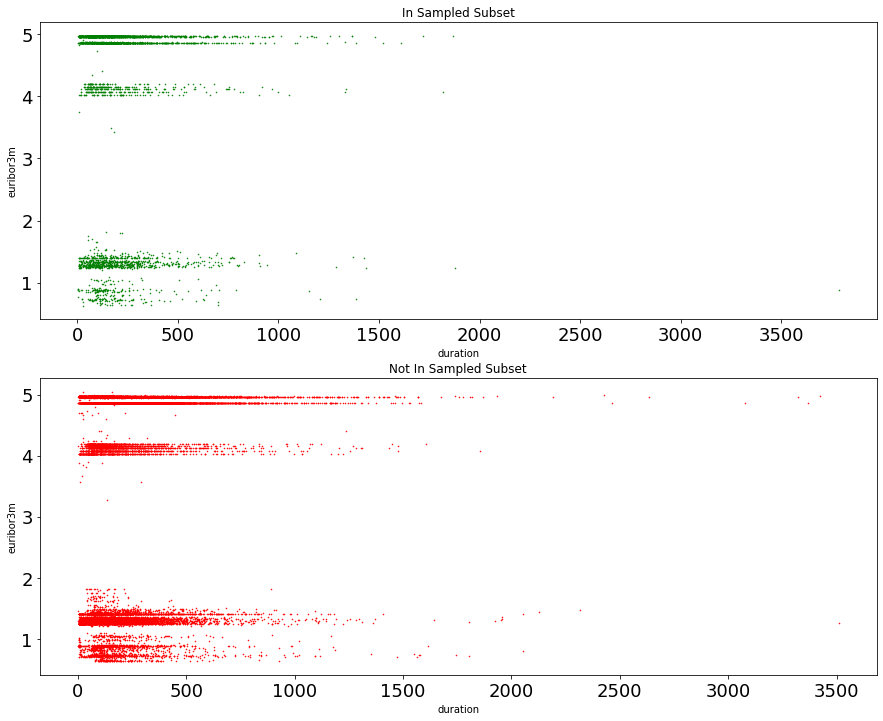

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(15, 12))
bias_analysis_df_2[bias_analysis_df_2['selected']==1.0].plot.scatter(\
        ax=ax[0], x='duration', y='euribor3m', c='g', fontsize=18, s=0.3)
ax[0].set_title('In Sampled Subset')
bias_analysis_df_2[bias_analysis_df_2['selected']==0.0].plot.scatter(\
        ax=ax[1], x='duration', y='euribor3m', c='r', fontsize=18, s=0.3)
ax[1].set_title('Not In Sampled Subset')
plt.show()

In general, it is important to only rely on explanatory variables in which the sampler has not introduced any bias collectively, and that are also insightful.

In [19]:
df_train_2.kxy.variable_selection(y_column, problem_type='classification')

[====================================================================================================] 100% ETA: 0s    Duration: 0s


,Variable,Running Achievable R-Squared,Running Achievable Accuracy
Selection Order,,,
0,No Variable,0.00,0.50
1,euribor3m,0.28,0.78
2,age,0.48,0.88
3,campaign,0.62,0.95
4,duration,0.62,0.95
5,housing_yes,0.62,0.95
6,marital_married,0.62,0.95
7,education_high.school,0.62,0.95
8,loan_no,0.62,0.95


### Compressed Model With Bias-Free Explanatory Variables

Below we show that, by focusing on the 4 explantory variables `euribor3m`, `age`, `campaign`, `duration`, which are both the top-4 most insightful explanatory variables and not too affect by sampling bias, we are able to achieve slightly better performance than using all 63 explanatory variables.

In [20]:
columns = ['euribor3m', 'age', 'campaign', 'duration']
x_train_3 = df_train_2[columns]
y_train_3 = df_train_2[y_column]
x_test_3 = df_test[columns]

# Training model with sampler 2 and variables not too affected by sampling bias
clf_3 = RandomForestClassifier(max_depth=10, random_state=0)
clf_3.fit(x_train_3, y_train_3)

# Evaluation (Model 3)
y_pred_3 = clf_3.predict(x_test_3)
conf_mat_3 = confusion_matrix(y_test, y_pred_3)
conf_mat_3 = pd.DataFrame(conf_mat_3, columns=['Predicted Would Not Subscribe', 'Predicted Would Subscribe'], \
                          index=['Did Not Subscribe', 'Subscribed'])
n_exp = np.sum(conf_mat_3.values)
acc3 = (conf_mat_3.values[0, 0]+conf_mat_3.values[1, 1])/n_exp
fp3 = conf_mat_3.values[0, 1]/n_exp
fn3 = conf_mat_3.values[1, 0]/n_exp

print('(Less Biased Sampler Compressed) Accuracy: %.2f, False-Positives: %.2f, False-Negatives: %.2f' % \
      (acc3, fp3, fn3))

(Less Biased Sampler Compressed) Accuracy: 0.85, False-Positives: 0.14, False-Negatives: 0.01


***Confusion Matrix: Focusing on Insightful Variables Least Affected By Bias***

In [21]:
conf_mat_3

,Predicted Would Not Subscribe,Predicted Would Subscribe
Did Not Subscribe,7566,1434
Subscribed,68,932
